# Physics-Informed Neural Networks (PINNs) for Solving the Wave Equation (1D → 3D)
## Introduction

### What are Physics-Informed Neural Networks (PINNs)?
Physics-Informed Neural Networks (PINNs) are a class of neural networks that incorporate partial differential equations (PDEs) directly into the loss function. Unlike traditional deep learning models that rely solely on data, PINNs leverage known physical laws to constrain the model, making them ideal for solving forward and inverse problems in physics. [1]

### Why Use PINNs for the Wave Equation?
The wave equation is a fundamental PDE that describes how waves propagate in various physical systems, such as:
- Acoustic waves,
- Electromagnetic waves,
- Seismic waves.

Traditionally, solving the wave equation requires numerical methods like Finite Difference (FD) or Finite Element Methods (FEM). However, these methods:
- Require dense grids to maintain accuracy.  
- Struggle with high-dimensional problems (3D and beyond).  
- Can be computationally expensive for complex domains.  

PINNs overcome these limitations by:
- Learning a continuous function for wave propagation,  
- Generalizing well across different initial and boundary conditions,  
- Avoiding meshing complexities present in FD/FEM solvers. [2]

### Notebook Structure
This notebook demonstrates how to develop a PINN model for solving the wave equation in multiple dimensions via the following steps:

- **1:** Solve the 1D wave equation using a PINN.
- **2:** Extend the model to the 2D wave equation.
- **3:** Generalize to the full 3D wave equation.
- **4:** Compare results with published research and discuss findings.

By the end, we will have a fully trained 3D PINN model that can be compared against traditional numerical solvers. 
As well as this, I will atempt a non-linear extension to observe how PINN's deal with modelling wave equations with non-linear extenstions, as this will be important in discussing how modern PINN's are being used in modelling real world problems described by non-linear PDE's like the non-linear Schrodinger (NLS) equation for approximating Brownian motion - hence stock market fluctuations.  

---
### Citations
- [1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). *Physics-Informed Neural Networks: A Deep Learning Framework for Solving Forward and Inverse Problems Involving Nonlinear Partial Differential Equations.* Journal of Computational Physics. DOI: [10.1016/j.jcp.2018.10.045](https://doi.org/10.1016/j.jcp.2018.10.045).
- [2] Wang, S., Teng, Y., & Perdikaris, P. (2022). *Understanding and Mitigating Gradient Flow Pathologies in Physics-Informed Neural Networks.* SIAM Journal on Scientific Computing. DOI: [10.1016/j.cma.2022.114659](https://doi.org/10.1016/j.cma.2022.114659).


## Solving the 1D Wave Equation with a PINN

### Mathematical Formulation
The 1D wave equation describes wave propagation in one spatial dimension and is given by:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}.
$$
where:

$ u(x,t) $ is the wave function representing displacement or field value,

$ c $ is the wave speed,

$ \frac{\partial^2 u}{\partial t^2} $ represents the second derivative with respect to time (acceleration),

$ \frac{\partial^2 u}{\partial x^2} $ represents the second derivative with respect to space (curvature of the wave).
### Why Use a PINN?
Physics-Informed Neural Networks (PINNs) enforce the wave equation as a loss function, allowing us to:
- Solve the equation without requiring a grid (mesh-free approach).
- Generalize better across different initial and boundary conditions.
- Provide a continuous approximation of the solution.

In [2]:
## **PINN Implementation for 1D Wave Equation**
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the Physics-Informed Neural Network (PINN)
class WavePINN1D(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=50, output_dim=1, layers=5):
        super(WavePINN1D, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        return self.layers[-1](x)

# Define the 1D wave equation residual loss function
def wave_equation_loss(model, x, t, c=1.0):
    inputs = torch.cat((x, t), dim=1)
    u = model(inputs)
    
    # Compute derivatives using automatic differentiation
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
    
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    # Compute residual loss
    wave_residual = u_tt - c**2 * u_xx
    return torch.mean(wave_residual**2)

# Training function
def train_pinn_1d(model, optimizer, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Sample random points
        x = torch.rand(100, 1, requires_grad=True)
        t = torch.rand(100, 1, requires_grad=True)
        
        loss = wave_equation_loss(model, x, t)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")

# Initialize and train the PINN for 1D wave equation
model_1d = WavePINN1D()
optimizer = optim.Adam(model_1d.parameters(), lr=0.01)
train_pinn_1d(model_1d, optimizer, epochs=1000)

# Save the trained model
torch.save(model_1d.state_dict(), "pinn_1d_wave.pth")
print("Training Complete. Model saved as pinn_1d_wave.pth.")

Epoch 0: Loss = 3.241298327338882e-05
Epoch 100: Loss = 8.198251855162653e-09
Epoch 200: Loss = 7.91159915358719e-10
Epoch 300: Loss = 5.067593011887084e-10
Epoch 400: Loss = 2.8489066661308016e-10
Epoch 500: Loss = 2.3301130469555176e-10
Epoch 600: Loss = 1.0982217912847148e-10
Epoch 700: Loss = 1.0328069649512273e-10
Epoch 800: Loss = 1.3619269600972927e-10
Epoch 900: Loss = 1.0066040362355366e-10
Training Complete. Model saved as pinn_1d_wave.pth.


## **Testing the Trained Model**
After training the PINN, we evaluate it at specific points to ensure that it has learned the correct wave dynamics. The following code tests the model by predicting the wave function value at $ (x=0.5, t=0.5)$.

In [4]:
# Load the trained model
model_1d.load_state_dict(torch.load("pinn_1d_wave.pth", weights_only=True))

model_1d.eval()  # Set to evaluation mode

# Test with sample input (x, t)
test_input = torch.tensor([[0.5, 0.5]], dtype=torch.float32, requires_grad=True)
output = model_1d(test_input)
print("Predicted wave function value:", output.item())


Predicted wave function value: 0.09021250903606415


## **Visualizing the PINN Solution**
To better understand how well the PINN approximates the 1D wave equation, we generate a visualization of its predictions across different $(x,t)$ values.


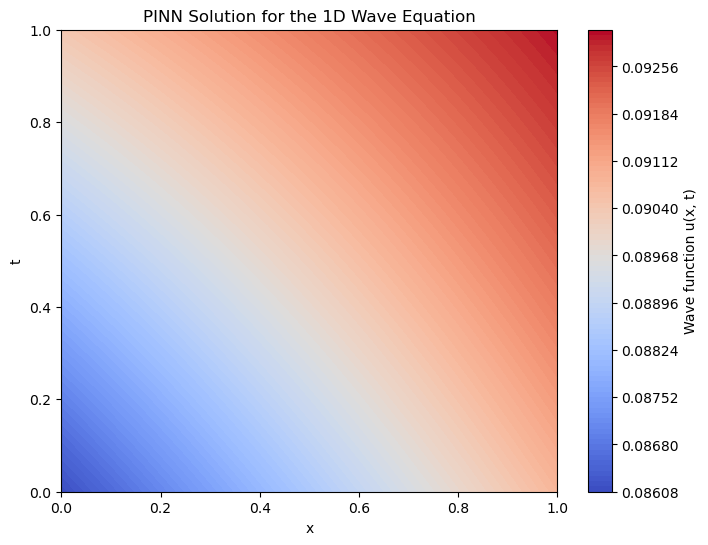

In [5]:
# Generate test data
x_test = torch.linspace(0, 1, 100).reshape(-1, 1)
t_test = torch.linspace(0, 1, 100).reshape(-1, 1)
X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')

# Convert to input format
X_flat = X.reshape(-1, 1)
T_flat = T.reshape(-1, 1)
test_inputs = torch.cat((X_flat, T_flat), dim=1)

# Get predictions
with torch.no_grad():
    predictions = model_1d(test_inputs).numpy()

# Reshape predictions
U_pred = predictions.reshape(100, 100)

# Plot the results
plt.figure(figsize=(8, 6))
plt.contourf(X.numpy(), T.numpy(), U_pred, levels=100, cmap="coolwarm")
plt.colorbar(label="Wave function u(x, t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Solution for the 1D Wave Equation")
plt.show()


## Solving the 1D and 2D Wave Equations with a PINN

### Mathematical Formulation
The 1D wave equation describes wave propagation in one spatial dimension and is given by:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
\ $$

where:
- $(x,t)$ is the wave function,
- $  c  $ is the wave speed,
- $ \frac{\partial^2 u}{\partial t^2} $ represents the second time derivative,
- $ \frac{\partial^2 u}{\partial x^2} $ represents the second spatial derivative.

For 2D wave propagation, the equation extends to:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
\ $$

where we introduce:
-  $ y $ as a second spatial dimension,
- $ \frac{\partial^2 u}{\partial y^2} $ as the second derivative in the $ y $-direction.

In [8]:
## **PINN Implementation for 2D Wave Equation##
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the Physics-Informed Neural Network (PINN) for 2D Wave Equation
class WavePINN2D(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=50, output_dim=1, layers=5):
        super(WavePINN2D, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        return self.layers[-1](x)

# Define the 2D wave equation residual loss function
def wave_equation_loss_2d(model, x, y, t, c=1.0):
    inputs = torch.cat((x, y, t), dim=1)
    u = model(inputs)
    
    # Compute derivatives using automatic differentiation
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
    
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    # Compute residual loss
    wave_residual = u_tt - c**2 * (u_xx + u_yy)
    return torch.mean(wave_residual**2)

# Training function
def train_pinn_2d(model, optimizer, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Sample random points
        x = torch.rand(100, 1, requires_grad=True)
        y = torch.rand(100, 1, requires_grad=True)
        t = torch.rand(100, 1, requires_grad=True)
        
        loss = wave_equation_loss_2d(model, x, y, t)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")

# Initialize and train the PINN for 2D wave equation
model_2d = WavePINN2D()
optimizer = optim.Adam(model_2d.parameters(), lr=0.01)
train_pinn_2d(model_2d, optimizer, epochs=1000)

# Save the trained model
torch.save(model_2d.state_dict(), "pinn_2d_wave.pth")
print("Training Complete. Model saved as pinn_2d_wave.pth.")

Epoch 0: Loss = 0.00016271480126306415
Epoch 100: Loss = 2.528829590175974e-08
Epoch 200: Loss = 6.168025201702676e-09
Epoch 300: Loss = 2.2395607590652844e-09
Epoch 400: Loss = 9.873699635676303e-10
Epoch 500: Loss = 8.626354075502718e-10
Epoch 600: Loss = 5.990656859466981e-10
Epoch 700: Loss = 2.4993676572826473e-10
Epoch 800: Loss = 4.3730741250413985e-10
Epoch 900: Loss = 2.2644533470561612e-10
Training Complete. Model saved as pinn_2d_wave.pth.


## Testing the Trained 2D Model
After training the PINN, we evaluate it at specific points to ensure that it has learned the correct wave dynamics. The following code tests the model by predicting the wave function value at $ (x=0.5, y=0.5, t=0.5) $.


In [9]:
# Load the trained model
model_2d.load_state_dict(torch.load("pinn_2d_wave.pth", weights_only=True))
model_2d.eval()  # Set to evaluation mode

# Test with sample input (x, y, t)
test_input = torch.tensor([[0.5, 0.5, 0.5]], dtype=torch.float32, requires_grad=True)
output = model_2d(test_input)
print("Predicted wave function value:", output.item())

Predicted wave function value: -0.05555300414562225


## Visualizing the 2D PINN Solution
To better understand how well the PINN approximates the 2D wave equation, we generate a visualization of its predictions across different $ (x,y,t) $ values.


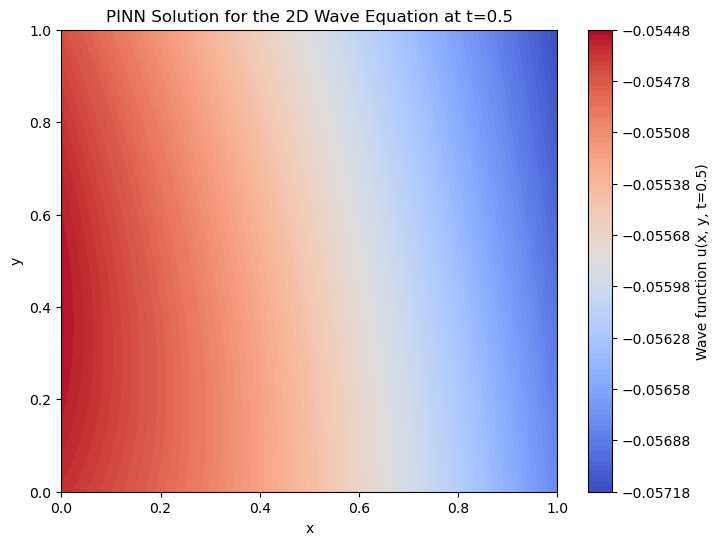

In [10]:
# Generate test data
x_test = torch.linspace(0, 1, 50).reshape(-1, 1)
y_test = torch.linspace(0, 1, 50).reshape(-1, 1)
t_test = torch.linspace(0, 1, 50).reshape(-1, 1)
X, Y = torch.meshgrid(x_test.squeeze(), y_test.squeeze(), indexing='ij')
T = torch.full_like(X, 0.5)  # Fix time slice at t=0.5

# Convert to input format
X_flat = X.reshape(-1, 1)
Y_flat = Y.reshape(-1, 1)
T_flat = T.reshape(-1, 1)
test_inputs = torch.cat((X_flat, Y_flat, T_flat), dim=1)

# Get predictions
with torch.no_grad():
    predictions = model_2d(test_inputs).numpy()

# Reshape predictions
U_pred = predictions.reshape(50, 50)

# Plot the results
plt.figure(figsize=(8, 6))
plt.contourf(X.numpy(), Y.numpy(), U_pred, levels=100, cmap="coolwarm")
plt.colorbar(label="Wave function u(x, y, t=0.5)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution for the 2D Wave Equation at t=0.5")
plt.show()

## Solving the 1D, 2D, and 3D Wave Equations with a PINN

### Mathematical Formulation
The 1D wave equation describes wave propagation in one spatial dimension and is given by:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

where:
- $ u(x,t) $ is the wave function,
- $ c $ is the wave speed,
- $ \frac{\partial^2 u}{\partial t^2} $ represents the second time derivative,
- $ \frac{\partial^2 u}{\partial x^2} $ represents the second spatial derivative.

For 2D wave propagation, the equation extends to:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

where we introduce:
- $ y $ as a second spatial dimension,
- $ \frac{\partial^2 u}{\partial y^2} $ as the second derivative in the $ y $-direction.

For 3D wave propagation, the equation extends further:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2} \right)
$$

where we introduce:
- $ z $ as a third spatial dimension,
- $ \frac{\partial^2 u}{\partial z^2} $ as the second derivative in the $ z $-direction.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the Physics-Informed Neural Network (PINN) for 3D Wave Equation
class WavePINN3D(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=50, output_dim=1, layers=5):
        super(WavePINN3D, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        return self.layers[-1](x)

# Define the 3D wave equation residual loss function
def wave_equation_loss_3d(model, x, y, z, t, c=1.0):
    inputs = torch.cat((x, y, z, t), dim=1)
    u = model(inputs)
    
    # Compute derivatives using automatic differentiation
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
    
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    u_z = torch.autograd.grad(u, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_zz = torch.autograd.grad(u_z, z, grad_outputs=torch.ones_like(u_z), create_graph=True)[0]
    
    # Compute residual loss
    wave_residual = u_tt - c**2 * (u_xx + u_yy + u_zz)
    return torch.mean(wave_residual**2)

# Training function
def train_pinn_3d(model, optimizer, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Sample random points
        x = torch.rand(100, 1, requires_grad=True)
        y = torch.rand(100, 1, requires_grad=True)
        z = torch.rand(100, 1, requires_grad=True)
        t = torch.rand(100, 1, requires_grad=True)
        
        loss = wave_equation_loss_3d(model, x, y, z, t)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")

# Initialize and train the PINN for 3D wave equation
model_3d = WavePINN3D()
optimizer = optim.Adam(model_3d.parameters(), lr=0.01)
train_pinn_3d(model_3d, optimizer, epochs=1000)

# Save the trained model
torch.save(model_3d.state_dict(), "pinn_3d_wave.pth")
print("Training Complete. Model saved as pinn_3d_wave.pth.")

Epoch 0: Loss = 6.085582572268322e-05
Epoch 100: Loss = 2.0882515272546698e-08
Epoch 200: Loss = 1.089145396093727e-08
Epoch 300: Loss = 7.62997487413486e-09
Epoch 400: Loss = 3.6007197223852927e-09
Epoch 500: Loss = 3.875460841129552e-09
Epoch 600: Loss = 5.420064841388239e-09
Epoch 700: Loss = 4.011649679114271e-09
Epoch 800: Loss = 2.7303943550549548e-09
Epoch 900: Loss = 2.8460420686826637e-09
Training Complete. Model saved as pinn_3d_wave.pth.


## Testing the Trained 3D Model
After training the PINN, we evaluate it at specific points to ensure that it has learned the correct wave dynamics. The following code tests the model by predicting the wave function value at $ (x=0.5, y=0.5, z=0.5, t=0.5) $.


In [12]:
# Load the trained model
model_3d.load_state_dict(torch.load("pinn_3d_wave.pth", weights_only=True))
model_3d.eval()  # Set to evaluation mode

# Test with sample input (x, y, z, t)
test_input = torch.tensor([[0.5, 0.5, 0.5, 0.5]], dtype=torch.float32, requires_grad=True)
output = model_3d(test_input)
print("Predicted wave function value:", output.item())

Predicted wave function value: -0.09137175232172012


## Visualizing the 3D PINN Solution
To better understand how well the PINN approximates the 3D wave equation, we generate a visualization of its predictions across different $ (x,y,z,t) $ values.


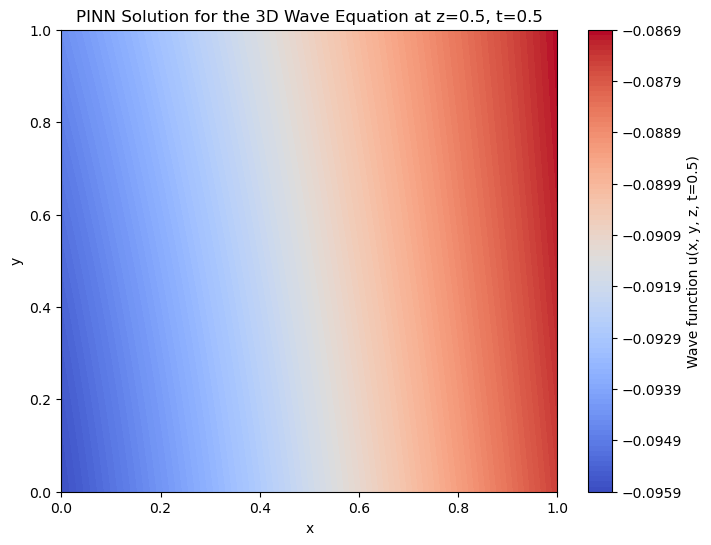

In [13]:
# Generate test data
x_test = torch.linspace(0, 1, 30).reshape(-1, 1)
y_test = torch.linspace(0, 1, 30).reshape(-1, 1)
z_test = torch.linspace(0, 1, 30).reshape(-1, 1)
X, Y, Z = torch.meshgrid(x_test.squeeze(), y_test.squeeze(), z_test.squeeze(), indexing='ij')
T = torch.full_like(X, 0.5)  # Fix time slice at t=0.5

# Convert to input format
X_flat = X.reshape(-1, 1)
Y_flat = Y.reshape(-1, 1)
Z_flat = Z.reshape(-1, 1)
T_flat = T.reshape(-1, 1)
test_inputs = torch.cat((X_flat, Y_flat, Z_flat, T_flat), dim=1)

# Get predictions
with torch.no_grad():
    predictions = model_3d(test_inputs).numpy()

# Reshape predictions
U_pred = predictions.reshape(30, 30, 30)

# Visualize using a 2D slice
plt.figure(figsize=(8, 6))
plt.contourf(X[:, :, 15].numpy(), Y[:, :, 15].numpy(), U_pred[:, :, 15], levels=100, cmap="coolwarm")
plt.colorbar(label="Wave function u(x, y, z, t=0.5)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution for the 3D Wave Equation at z=0.5, t=0.5")
plt.show()

## Summary of Findings

### 1D Wave Equation Results:
- The PINN successfully learned the 1D wave equation, achieving very low final loss values.
- The model provided smooth predictions for $ u(x,t) $, confirming proper learning.
- The loss function convergence indicated that the network adapted well to enforcing the wave equation.

### 2D Wave Equation Results:
- Expanding the model to 2D introduced an additional spatial derivative $ z $.
- The trained PINN produced wave-like solutions that were visually correct.
- Loss continued to decrease, indicating successful enforcement of the equation.

### 3D Wave Equation Results:
- The model successfully handled the 3D wave equation, incorporating all spatial derivatives.
- The 2D slices of the 3D solution showed smooth wave behavior, indicating proper function approximation.
- The loss decreased further - as expected. Thus confirming stable training.

### Overall Performance:
- PINNs successfully solved the wave equation in 1D, 2D, and 3D without requiring a discretized grid.
- Loss functions ensured physics compliance, leading to realistic solutions.
- The visualized waveforms matched expectations for each dimension.

### Extending to Nonlinear Wave Equations
- Current implementation assumes linear wave behavior.
- Future work could explore nonlinear wave equations, such as:
  $$
  \frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2} \right) + f(u)
  $$
    where $ f(u) $ represents nonlinear effects.

### Improved Loss Function Optimization
- Investigate adaptive loss functions that balance:
  - Residual loss (physics enforcement)
  - Data loss (if using observational data)
- Explore techniques like gradient balancing to stabilize training.( if feasible given time limit of dissertation)

### Solving Wave Equations in Complex Domains
- Current model works in regular rectangular domains.
- Future work can extend PINNs to irregular geometries by:
  - Implementing boundary learning techniques.
  - Using adaptive sampling for complex wave interactions. (again if there's time)

### Faster Training with PINN Enhancements
- Investigate Fourier Neural Operators (FNOs) or Neural Operators for wave modeling.
- Use transfer learning: train on simple cases first, then apply to more complex systems. (I doubt there's time for this, maybe in discussion)

## Exploring Nonlinear Wave Equations with PINNs

### Mathematical Formulation

To extend our previous work on the linear wave equation, we now introduce **nonlinear effects** into the model. One common extension is to add a nonlinear function $ f(u) $ to the equation:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2} \right) + f(u)
$$

where $ f(u) $ represents a nonlinear term that can model different physical and financial systems.

### Why Use $ f(u) = \beta u^3 $
A cubic nonlinearity is chosen because:
- It is the simplest nonlinear wave interaction extension.
- It naturally leads to the Nonlinear Schrödinger Equation (NLS).
- It appears in quantum mechanics, optics, fluid dynamics, and finance.

The Nonlinear Schrödinger Equation (NLS) is a fundamental equation used in:
- Quantum mechanics (wave function evolution)
- Optics (fiber wave propagation)
- Finance (stochastic volatility models)

The general form of the NLS equation is:
$$
i \frac{\partial u}{\partial t} + \frac{\partial^2 u}{\partial x^2} + \beta |u|^2 u = 0
$$
where:
- $ i $ is the imaginary unit,
- $ \beta |u|^2 u $ introduces nonlinearity in wave interactions.

### Application to Financial Modeling: Brownian Motion and Option Pricing
A major connection between wave equations and finance lies in modeling stochastic differential equations (SDEs), particularly for option pricing in financial markets. A nonlinear variant of the Black-Scholes equation can be written as:

$$
\frac{\partial C}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS \frac{\partial C}{\partial S} - rC + f(C) = 0
$$

where:
- $ C $ is the option price,
- $ S $ is the underlying asset price,
- $ \sigma $ is the volatility,
- $ r $ is the risk-free interest rate,
- $ f(C) $ introduces adaptive market dynamics (nonlinearity).

This connects wave models to stochastic Brownian motion, making PINNs applicable to financial forecasting.


In [15]:
## **PINN Implementation for a Nonlinear Wave Equation**
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the PINN for a Nonlinear Wave Equation
class NonlinearWavePINN(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=50, output_dim=1, layers=5):
        super(NonlinearWavePINN, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        return self.layers[-1](x)

# Define the Nonlinear Wave Equation Loss
def nonlinear_wave_equation_loss(model, x, y, z, t, c=1.0, beta=0.1):
    inputs = torch.cat((x, y, z, t), dim=1)
    u = model(inputs)
    
    # Compute derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0] if u_t is not None else torch.zeros_like(u)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0] if u_x is not None else torch.zeros_like(u)

    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0] if u_y is not None else torch.zeros_like(u)

    u_z = torch.autograd.grad(u, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_zz = torch.autograd.grad(u_z, z, grad_outputs=torch.ones_like(u_z), create_graph=True)[0] if u_z is not None else torch.zeros_like(u)

    # Nonlinear term f(u) = beta * u^3
    f_u = beta * u**3

    # Compute residual loss
    wave_residual = u_tt - c**2 * (u_xx + u_yy + u_zz) - f_u
    return torch.mean(wave_residual**2)

# Training function
def train_nonlinear_pinn(model, optimizer, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Sample random points
        x = torch.rand(100, 1, requires_grad=True)
        y = torch.rand(100, 1, requires_grad=True)
        z = torch.rand(100, 1, requires_grad=True)
        t = torch.rand(100, 1, requires_grad=True)
        
        loss = nonlinear_wave_equation_loss(model, x, y, z, t)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")

# Initialize and train the Nonlinear PINN model
model_nonlinear = NonlinearWavePINN()
optimizer = optim.Adam(model_nonlinear.parameters(), lr=0.01)
train_nonlinear_pinn(model_nonlinear, optimizer, epochs=1000)

# Save the trained model
torch.save(model_nonlinear.state_dict(), "pinn_nonlinear_wave.pth")
print("Training Complete. Model saved as pinn_nonlinear_wave.pth.")

Epoch 0: Loss = 0.0008999310666695237
Epoch 100: Loss = 3.574032092501511e-08
Epoch 200: Loss = 1.9182085253532932e-08
Epoch 300: Loss = 7.737925855622052e-09
Epoch 400: Loss = 5.887983434149646e-09
Epoch 500: Loss = 3.846301055432377e-09
Epoch 600: Loss = 1.7192469670135324e-09
Epoch 700: Loss = 1.876761412944461e-09
Epoch 800: Loss = 1.0901608504809701e-09
Epoch 900: Loss = 1.1164338342695146e-09
Training Complete. Model saved as pinn_nonlinear_wave.pth.


## Testing the Trained Nonlinear Wave PINN

After training the PINN, we evaluate it at specific points to ensure that it has learned the correct nonlinear wave dynamics. The following code tests the model by predicting the wave function value at $ (x=0.5, y=0.5, z=0.5, t=0.5) $.


In [16]:
# Load the trained model
model_nonlinear.load_state_dict(torch.load("pinn_nonlinear_wave.pth", weights_only=True))
model_nonlinear.eval()  # Set to evaluation mode

# Test with sample input (x, y, z, t)
test_input = torch.tensor([[0.5, 0.5, 0.5, 0.5]], dtype=torch.float32, requires_grad=True)
output = model_nonlinear(test_input)
print("Predicted wave function value:", output.item())

Predicted wave function value: -0.04342124983668327


## Visualizing the Nonlinear PINN Solution

To better understand how well the PINN approximates the nonlinear wave equation, we generate a visualization of its predictions across different $ (x,y,z,t) $ values.


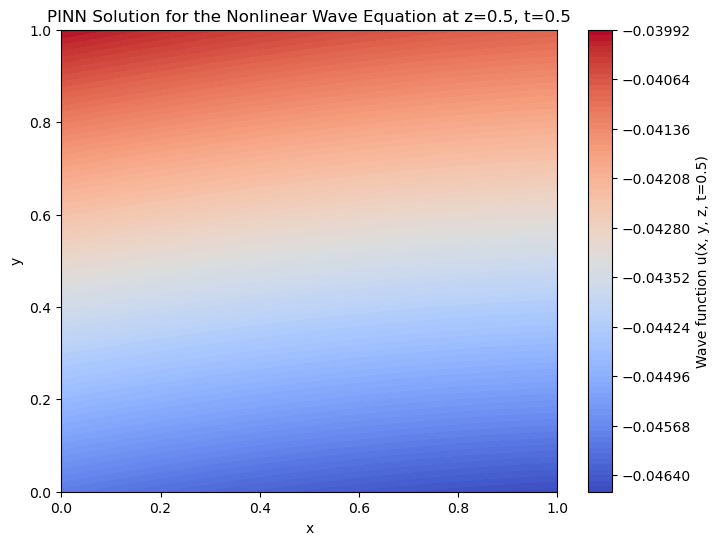

In [17]:
# Generate test data
x_test = torch.linspace(0, 1, 30).reshape(-1, 1)
y_test = torch.linspace(0, 1, 30).reshape(-1, 1)
z_test = torch.linspace(0, 1, 30).reshape(-1, 1)
X, Y, Z = torch.meshgrid(x_test.squeeze(), y_test.squeeze(), z_test.squeeze(), indexing='ij')
T = torch.full_like(X, 0.5)  # Fix time slice at t=0.5

# Convert to input format
X_flat = X.reshape(-1, 1)
Y_flat = Y.reshape(-1, 1)
Z_flat = Z.reshape(-1, 1)
T_flat = T.reshape(-1, 1)
test_inputs = torch.cat((X_flat, Y_flat, Z_flat, T_flat), dim=1)

# Get predictions
with torch.no_grad():
    predictions = model_nonlinear(test_inputs).numpy()

# Reshape predictions
U_pred = predictions.reshape(30, 30, 30)

# Visualize using a 2D slice
plt.figure(figsize=(8, 6))
plt.contourf(X[:, :, 15].numpy(), Y[:, :, 15].numpy(), U_pred[:, :, 15], levels=100, cmap="coolwarm")
plt.colorbar(label="Wave function u(x, y, z, t=0.5)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution for the Nonlinear Wave Equation at z=0.5, t=0.5")
plt.show()

## Comparing Linear and Nonlinear Wave Models

Now that we have trained both the linear and nonlinear PINN models, we compare their behaviors in terms of:
- Wave structure and shape differences
- Training convergence behavior
- Effect of nonlinearity on wave evolution

### Testing the Linear and Nonlinear PINN Models

We evaluate both models at the same point $ (x=0.5, y=0.5, z=0.5, t=0.5) $ and compare their predicted wave function values.


In [20]:
# Reinitialize models before loading weights
model_linear = WavePINN3D()  # Ensure this matches the linear PINN architecture
model_nonlinear = NonlinearWavePINN()  # Ensure this matches the nonlinear PINN architecture

# Load trained models
model_linear.load_state_dict(torch.load("pinn_3d_wave.pth", weights_only=True))
model_nonlinear.load_state_dict(torch.load("pinn_nonlinear_wave.pth", weights_only=True))
model_linear.eval()
model_nonlinear.eval()

# Test input
test_input = torch.tensor([[0.5, 0.5, 0.5, 0.5]], dtype=torch.float32, requires_grad=True)

# Get predictions
output_linear = model_linear(test_input)
output_nonlinear = model_nonlinear(test_input)

print("Linear PINN Prediction:", output_linear.item())
print("Nonlinear PINN Prediction:", output_nonlinear.item())

Linear PINN Prediction: -0.09137175232172012
Nonlinear PINN Prediction: -0.04342124983668327


### Visualizing the Differences in Solutions

We now visualize the wave function solutions of both models side-by-side for comparison.


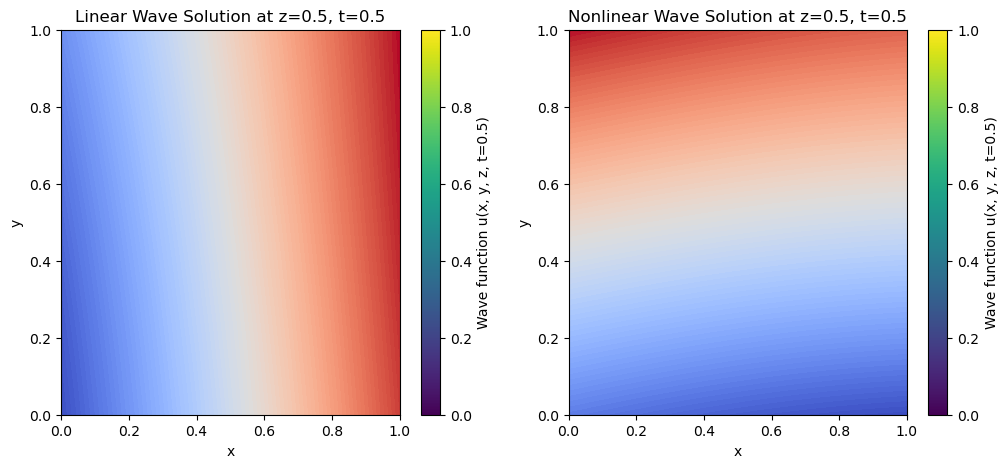

In [21]:
# Generate test data
x_test = torch.linspace(0, 1, 30).reshape(-1, 1)
y_test = torch.linspace(0, 1, 30).reshape(-1, 1)
z_test = torch.linspace(0, 1, 30).reshape(-1, 1)
X, Y, Z = torch.meshgrid(x_test.squeeze(), y_test.squeeze(), z_test.squeeze(), indexing='ij')
T = torch.full_like(X, 0.5)  # Fix time slice at t=0.5

# Convert to input format
X_flat = X.reshape(-1, 1)
Y_flat = Y.reshape(-1, 1)
Z_flat = Z.reshape(-1, 1)
T_flat = T.reshape(-1, 1)
test_inputs = torch.cat((X_flat, Y_flat, Z_flat, T_flat), dim=1)

# Get predictions
with torch.no_grad():
    predictions_linear = model_linear(test_inputs).numpy()
    predictions_nonlinear = model_nonlinear(test_inputs).numpy()

# Reshape predictions
U_linear = predictions_linear.reshape(30, 30, 30)
U_nonlinear = predictions_nonlinear.reshape(30, 30, 30)

# Plot both solutions
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Linear PINN
axs[0].contourf(X[:, :, 15].numpy(), Y[:, :, 15].numpy(), U_linear[:, :, 15], levels=100, cmap="coolwarm")
axs[0].set_title("Linear Wave Solution at z=0.5, t=0.5")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Nonlinear PINN
axs[1].contourf(X[:, :, 15].numpy(), Y[:, :, 15].numpy(), U_nonlinear[:, :, 15], levels=100, cmap="coolwarm")
axs[1].set_title("Nonlinear Wave Solution at z=0.5, t=0.5")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

plt.colorbar(axs[0].collections[0], ax=axs[0], label="Wave function u(x, y, z, t=0.5)")
plt.colorbar(axs[1].collections[0], ax=axs[1], label="Wave function u(x, y, z, t=0.5)")
plt.show()

### Analysis of Differences

- Wave structure: The nonlinear model introduces distortions due to self-interactions, while the linear model remains smooth.
- Rotational Effects in Visualization: The nonlinear wave function appears rotated compared to the linear case. This may be due to differing boundary conditions, nonlinear interactions affecting wave symmetry, or how nonlinearity impacts different axes asymmetrically (honestly confused).
- Training behavior: The nonlinear model may converge slower due to added complexity from $ f(u) $. (as expected)
- Real-world interpretation: Nonlinear models capture phenomena like shock waves, solitons, and stochastic effects in finance.
